# Looking at the Intersectionality of Environmental Themes found in GDELT Global Knowledge Graph Dataset using Network Graphs 

# Executive Summary

In 2015, the United Nations defined 17 sustainable development goals (SDGs) to provide a shared blueprint for peace and prosperity for the people and the planet. The goals recognize that ending poverty and other deprivations should go hand-in-hand with strategies for economic growth and development. The goals and targets are specific on what should be achieved by 2030. 

Five (5) years have  passed since the UN-member countries approved and committed to the SDGs which leads us to our question: how are we doing  with respect of achieving the Sustainable Development Goals -- to be specific in the frontier of Climate Change?

In this project, we present a way to understand how conversations and activities are connected and have been shifting (or have not been shifting) towards a more sustainable agenda. We used the GDELTV2 dataset found in Amazon Web Services, which contains more than 5.7 Terabytes of data. The Global Database of Events Language and Tone contains related news and articles from more than 100 countries. The Global Knowledge Graph (GKG) provides us with expanded ability to quantify and visualize human society beyond just occurrences by providing  data related to several themes, topics, organizations, and countries..

We achieved this by using Dask, a distributed computing package available for Python. We sampled a total of 22GB from the 2019 data (April 2019) and processed them to obtain an adjacency matrix for the Network graph. With the use of the Network Graph, we developed insights related to Climate Change and the environment, in general. 

From our results, we concluded that we are still far from achieving the targets set by the United Nations. Our Network Graph showed that efforts remained siloed because these themes are located in opposite directions of the network graph. However, we found that themes like "CLOUD_COMPUTING", "CENTRAL_BANKS", "CANCER"" are connected albeit located in the fringes of the graph. The presence of such themes emphasizes the intersectionality of issues and why we have to look at it from a systems perspective


# Introduction
 
Multimedia tools, news articles, websites, researches, and events are sources of information in many countries. Society, in general, rely on them to obtain information on different topics including natural climate disasters, policies and even the mundane. Considering this, it can be expected that if the UN SDGs  are in place and are shaping the direction of countries, news and articles related to the SDGs are commonplace. This provides us with an opportunity to use these events, knowledge, and literature sources to develop a way to measure impact and evaluate performance of countries in each of the 17 SDGs. The Global Database of Events, Language, and Tone (GDELT) allows us to do us with the help of their Global Knowledge Graph, which include tags of news and articles and the place of origin.

We will only be using data from April 2019 as the dataset contain several terabytes of information. April 2019 is the most recent month that we found in the AWS S3 bucket, but the original source have more recent ones. In this notebook, we detail how we handled the 22GB worth of information contained in the April 2019 repository of GKG and afterwards, we show the main network graph that we developed for the paper.

# Dataset

The Global Knowledge Graph Version 2.1 is a dataset from GDELT which expands the ability to understand articles. In total in contains 5.7 Terabytes of data collected since 2015. It has 27 features from which we  only used 4. The dataset can be accessed at `s3://gdelt-open-data/v2/gkg/201904*.gkg.csv`.

We describe below the relevant features from our sample. For more information, you may visit the official documentation located [here](http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf)

(Taken from GDELT GKG Codebook V2.1)

- **GKGRECORDID:** (string) Unique identifier which uses a semisequential numbering ID that takes the form of a date and a code. “YYYYMMDDHHMMSS-X” or “YYYYMMDDHHMMSS-TX”.
- **V2.1DATE:** (integer) The date in YYYYMMDDHHMMSS format when the news media used to construct the GKG file was published
- **V2SOURCECOLLECTIONIDENTIFIER:** (integer) The numeric identifier that refers to the source collection the document came from and is used to interpret the DocumentIdentifier in the next column.
- **V2SOURCECOMMONNAME:** (text) Human-friendly identifier of the source of the document. For material originating from the open web with a URL this field will contain the toplevel domain the page was from.
- **V2DOCUMENTIDENTIFIER:** (text) Unique external identifier for the source document.It can be used to uniquely identify the document and access.
- **V1COUNTS:** (semicolon-delimited blocks, with pound symbol (“#”) delimited fields) List of Counts found in this document. Each Count found is separated with a semicolon, while the fields within a Count are separated by the pound symbol (“#”).
- **V2.1COUNTS.:** (semicolon-delimited blocks, with pound symbol (“#”) delimited fields) Identical to the V1COUNTS field except that it adds a final additional field to the end of each entry that records its approximate character offset in the document.
- **V1THEMES:** (semi-colon-delimited) List of all Themes found in the document. For the complete list of possible themes
- **V2ENHANCEDTHEMES:** (semicolon-delimited blocks, with comma-delimited fields) All GKG themes referenced in the document, along with the character offsets of approximately where in the document they were found.
- **V1LOCATIONS:** (semicolon-delimited blocks, with pound symbol (“#”) delimited fields) All locations found in the text, extracted through the Leetaru algorithm.
- **V2ENHANCEDLOCATIONS:** semicolon-delimited blocks, with pound symbol (“#”) delimited fields) Identical to the V1LOCATIONS field with the primary exception of an extra field appended to the end of each location block after its FeatureID.
- **V1PERSONS:** (semicolon-delimited) List of all person names found in the text, extracted through the Leetaru algorithm.
- **V2ENHANCEDPERSONS:** (semicolon-delimited blocks, with comma-delimited fields) List of all person names referenced in the document, along with the character offsets of approximately where in the document they were found.
- **V1ORGANIZATIONS.**: (semicolon-delimited) List of all company and organization names found in the text, extracted through the Leetaru algorithm.

For the project, we only used `GKGRECORDID`, `V1THEMES`, `V2ENHANCEDTHEMES`, and `V1LOCATIONS` which contain data on the timestamp, themes of the document,  and mentioned locations locations.


Since the dataset is available in Jojie, we will be using a bash command to show the size of the dataset chosen

In [254]:
!du -ch /mnt/data/public/gdeltv2/gkg/201904* | tail -1


22G	total


# Methodology

The set up for the paper is as follows:
- Reading the Data using Dask and Setting up the Distributed Client
- Data Cleaning and Pre-Processing
- Generation of Bags of Words and Formation of the Cooccurrence Matrix
- Development of the Network Graph

Details of which are included in the Implementation section

# Implementation

**Set-up Distributed Client**

The our set up is comprised of 12 workers (t2.large EC2 instance) with a combined memory of 100.16 GB. Initially, we intended to run the entire 2019 GDELT GKG dataset (rougly 160GB) but decided to decrease the scope to just the April 2019 dataset.

In [1]:
from dask.distributed import Client
client = Client('54.221.250.197:8786')
client.restart() # To ensure that the Client starts fresh

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1129: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2.25.0        | 2.30.0        | 2.30.0        |
| distributed | 2.30.0        | 2.30.1        | 2.30.1        |
| numpy       | 1.18.5        | 1.19.2        | 1.19.2        |
| python      | 3.8.6.final.0 | 3.8.5.final.0 | 3.8.5.final.0 |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://54.221.250.197:8786 Dashboard: http://54.221.250.197:8787/status,Cluster Workers: 12 Cores: 24 Memory: 100.16 GB


**Reading the file from the GDELT S3 bucket located at `s3://gdelt-open-data/v2/gkg/`.**

Since our concern is to obtain the occurrences of themes, we only extracted columns 7 and 8 which both refers to the themes of the article/ resource in that row.

In [3]:
import dask.dataframe as dd

gkg = dd.read_csv(
            's3://gdelt-open-data/v2/gkg/201904*.gkg.csv', 
            storage_options={'anon': True}, 
            assume_missing=True, 
            sep='\t', header=None, usecols=[1,7,8], 
            names=['dates', 'theme1', 'theme2']
            )

Some rows contain null values. Furthermore, the text format of the strings are not consistent, i.e. `theme2` tags are succeeded by a comma and a numeric string while `theme1` tags are simple separated by semi-colons. 

In [21]:
gkg

,dates,theme1,theme2
npartitions=2880,,,
,float64,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


### **Data Cleaning and Pre-Processing**

The general pre-processing idea was to transform the dask dataframe into a dask bag of sentences (or documents). Each sentence or document contains whitespace-separated theme tags.  

Themes from both columns (`theme1` and `theme2`) were parsed and merged to form sets of themes. The `set` data type ensures that no repeats/ duplicates exist in the row. Then, the sets were joined to formed space-separated strings of themes. Finally, the dask dataframe is converted into a dask bag.

In [22]:
def process_gkg(gkg):
    """Preprocess the `gkg` dataframe
    
    Parameter:
    ----------
    
    gkg: dask.dataframe
        Dask.DataFrame of themes available from GDELT GKG repository
    Return:
    -------
    gkg: dask.dataframe
        Dask.DataFrame with combined parsed themes and datetime column.
    """
    
    def theme_parser(x):
        """Helper function to parse the themes"""
        import re
        ptn = r'[A-Z_]+(?=[,;])|(?<=[A-Z]{2}_)\d+_[A-Z_]+(?=[,;])'
        parser = re.compile(ptn)
#   
        return set([re.sub(r'(\d+_)(?=[A-Z]+)', '', x) 
                    for x in parser.findall(x)])

    def merger(x):
        """Helper function to combine theme1 and theme2 columns"""
        set1 = theme_parser(str(x.theme1))
        set2 = theme_parser(str(x.theme2))
        return (set1).union(set2)
                   

    gkg.dates = dd.to_datetime(gkg.dates, format='%Y%m%d%H%M%S')
    gkg = gkg.dropna(how='all', subset=['theme1', 'theme2'])
    gkg = gkg.set_index('dates')
    gkg['all_themes'] = gkg.apply(lambda x: merger(x.astype(str)), 
                                  axis=1,
                                  meta=('', 'object'))
    gkg = gkg.drop(['theme1', 'theme2'], axis=1)
    return gkg.reset_index()
    

In [23]:
gkg2 = process_gkg(gkg)

# persist helps in suceeding calls 
gkg2.persist()

,dates,all_themes
npartitions=2880,,
,datetime64[ns],object
,...,...
...,...,...
,...,...
,...,...


### Visualization of tags related to Climate Change

In this section we will explore how different tags related to Climate Change have been present in the news articles per countries. To do this we will be substracting the locations and tags using some feature extraction techniques and preprocessing. We will use regular expression to support us with this task.   

In [1]:
import dask as da
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar

We will get a sample of 40% of the 22 Gigabytes, which is estimated to be 8.8 G. We will extract the tags and locations for this task and drop all NA rows. We will proceed adter this to reset index.  

After this we will extract the locations using some regular expresions. An important task is to define the same number of partitions so we can concatenate out new locations feature with our dask dataframe. 

In [6]:
gkg = dd.read_csv('/mnt/data/public/gdeltv2/gkg/201904*',
              assume_missing=True, 
              compression = 'zip', sep = '\t', usecols = [7,8,9], 
              names = ['tags','tags2', 'locations']).sample(.4).dropna()

/opt/conda/lib/python3.8/site-packages/dask/dataframe/core.py:1345: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)


In [7]:
gkg = gkg.dropna().reset_index(drop = True)

In [10]:
gkg = gkg.repartition(npartitions=200)

In [11]:
region = gkg['locations'].str.extract(r'\S+#(\D{2})#').repartition(npartitions=200)

In [12]:
gkg = dd.concat([gkg, region] , axis = 1).persist()

/opt/conda/lib/python3.8/site-packages/dask/dataframe/multi.py:1093: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [13]:
gkg

,tags,tags2,locations,0
npartitions=200,,,,
,object,object,object,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


Lets visualize some topics related to climate change:

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g0oc2q_9 because the default path (/home/awhite/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [15]:
env = gkg[gkg['tags'].str.match(r'(:?\b(ENVIRONMENT)|\S+(ENVIRONMENT))')]
gbenv = env.groupby(0).count()['tags'].compute()

Text(0, 0.5, 'Countries')

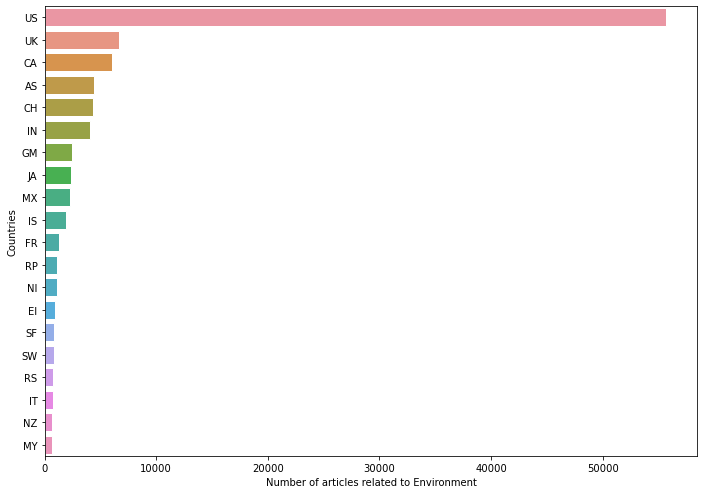

In [16]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_theme(style="whitegrid")
sns.barplot(x = gbenv.sort_values(ascending = False)[:20].values, y = gbenv.sort_values(ascending = False)[:20].index )
plt.xlabel('Number of articles related to Environment')
plt.ylabel('Countries')

In [17]:
climate = gkg[gkg['tags'].str.match(r'(:?\b(CLIMATE)|\S+(CLIMATE))')]
gbcli = climate.groupby(0).count()['tags'].compute()

Text(0, 0.5, 'Countries')

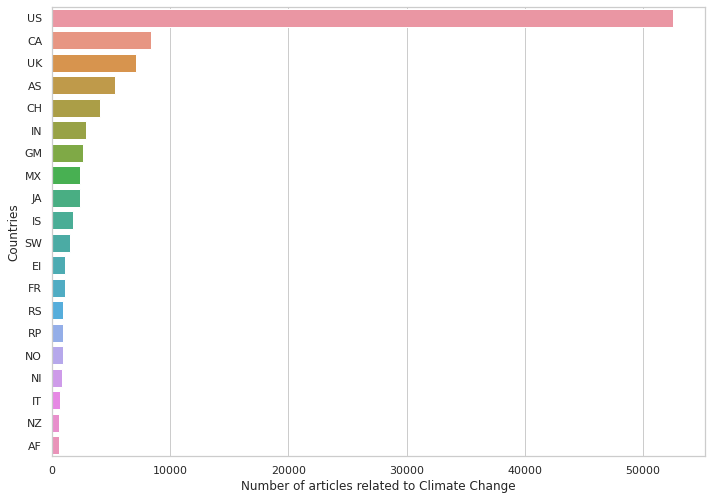

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_theme(style="whitegrid")
sns.barplot(x = gbcli.sort_values(ascending = False)[:20].values, y = gbcli.sort_values(ascending = False)[:20].index )
plt.xlabel('Number of articles related to Climate Change')
plt.ylabel('Countries')

### Preprocessing:  Generate Bags-of-Words representation of Themes

**Filtering of rows based on seed topics** 

We identified several seed "themes" or "topics" from the GDELTV1 category list which we found relevant to the topic explored (Environment and the Sustainable Development Goals). The `seed_themes` allow us to extract other theme tags that are found together with our chosen theme.

In [250]:
with open('themes.txt', 'r') as f:
    theme_areas = set([theme.strip() for theme in f.readlines()])
    
print(theme_areas)

{'ENV_OIL', 'SLFID_MINERAL_RESOURCES', 'ENV_MINING', 'STRIKE', 'ENV_FORESTRY', 'AGRICULTURE', 'MOVEMENT_SOCIAL', 'ENV_BIOFUEL', 'ENV_GEOTHERMAL', 'ENV_GREEN', 'ENV_CLIMATECHANGE', 'URBAN_SPRAWL', 'ENV_WATERWAYS', 'ENV_WINDPOWER', 'ENV_OVERFISH', 'ENV_SOLAR', 'NATURAL_DISASTER', 'ENV_NATURALGAS', 'ENV_SPECIESEXTINCT', 'TAX_FOODSTAPLES', 'ENV_HYDRO', 'FOOD_STAPLE', 'ENV_NUCLEARPOWER', 'POVERTY', 'UNREST_HUNGERSTRIKE', 'SLFID_NATURAL_RESOURCES', 'GENERAL_GOVERNMENT', 'ENV_METALS', 'ENV_SPECIESENDANGERED', 'ENV_CARBONCAPTURE', 'FOOD_SECURITY', 'ENV_POACHING', 'ENV_COAL', 'SCIENCE', 'ENV_DEFORESTATION', 'WATER_SECURITY', 'URBAN', 'GENTRIFICATION', 'POWER_OUTAGE', 'MOVEMENT_GENERAL', 'MOVEMENT_OTHER', 'ENV_FISHERY', 'PROTEST'}


In [66]:
def process_themes(gkg, theme_areas, df_range=(0.05, 0.95)):
    """Generate a bag-of-words (themes) given a dask dataframe.
    
    Parameters
    ----------
    gkg : dask dataframe
        GDELT knowledge graph data
    theme_areas: set
        set of `seed_themes` to filter the dataframe
    df_range: tuple of float or tuple of int
        input to the CountVectorizer class (df_min, df_max)
    
    Return
    ------
    X_theme : dask.array
        Sparse array from the CountVectorizer
    labels : list/ array-like
        Vocabulary/ feature names of the Vectorizer"""
    from dask_ml.feature_extraction.text import CountVectorizer
    import dask.bag as db
    import dask.array as da
    
  
    themes = gkg.all_themes
    subset_themes = (themes.loc[themes.map(lambda x: 
                                      len(x.intersection(theme_areas))>0, 
                                      meta=('filt', 'bool'))]
                       .map(lambda x: ' '.join(x), 
                            meta=('all_themes', 'object'))
                       .to_bag()
                       .persist())

    
    
    vectorizer = CountVectorizer(lowercase=False,
                                 min_df=df_range[0], 
                                 max_df=df_range[1])
    X_themes = (vectorizer.fit_transform(subset_themes).persist())
    labels = vectorizer.get_feature_names()
    print(f'Done with compute. Found a total of {len(labels)} topics!')
    
    return (X_themes, labels)


In [84]:
X_themes, labels = process_themes(gkg2, theme_areas)

Done with compute. Found a total of 821 topics!


**Convert Sparse Dask array to Dense Dask array**

The array that CountVectorizer gives is a sparse.array(). We converted all blocks to dense arrays and recomputed the chunk sizes. 

In [97]:
X_themes1 = (X_themes.map_blocks(lambda x: x.toarray(), 
                                 dtype=X_themes.dtype)
                     .persist()
                     .compute_chunk_sizes())


,Array,Chunk
Bytes,8.04 GB,10.34 MB
Shape,"(1224764, 821)","(1574, 821)"
Count,3004 Tasks,1502 Chunks
Type,int64,numpy.ndarray


### Compute the Co-Occurrence Matrix that will serve as an Adjancency Matrix of the Network Graph

**Compute the Co-occurrence Matrix**

The Co-occurence matrix shows how many times each word appear together with another word. The co-occurrence counts can be obtained using the dot product of the term-document matrix ($\mathbf{T} x \mathbf{D}$) with the document-term matrix ($\mathbf{D} x \mathbf{T}$).

In [110]:
co_matrix = da.dot(X_themes1.transpose(), X_themes1)
co_matrix.compute_chunk_sizes()

dask.array<sum-aggregate, shape=(821, 821), dtype=int64, chunksize=(821, 821), chunktype=numpy.ndarray>

Finally, we compute the co-occurrence matrix to memory. We also saved the co-occurrence matrix into a `.csv` file to ensure that we do not have to repeat the the processes in previous steps. 

In [112]:
co_matrix1 = co_matrix.compute()

In [ ]:
import pandas as pd
pd.DataFrame(co_matrix1, columns=labels, index=labels).to_csv('co_matrix.csv')

In [137]:
co_matrix = pd.read_csv('co_matrix.csv', index_col=0)
labels = co_matrix1.columns

# Rescale the matrix 
co_matrix2 = np.round(co_matrix*1000/co_matrix.max().max(), 2)

# Preview of the Co-occurrence Matrix
co_matrix2

,ACCESS_AND_CONNECTIVITY,ACTIVE_LABOR_MARKET_POLICIES,ACT_MAKESTATEMENT,AFFECT,AGRICULTURAL_RISK_AND_SECURITY,AGRICULTURAL_WATER_MANAGEMENT,AGRICULTURE,AGRICULTURE_AND_FOOD_SECURITY,AIRPORTS,AIR_TRANSPORT,...,_MISSINGFOUNDTRAPPEDPEOPLE,_NEED_OF_SHELTERS,_RESPONSEAGENCIESATCRISIS,_SAFETY,_SERVICESNEEDEDOFFERED,_SUPPLIES,_UPDATESSYMPATHY,_WATER_SANITATION,_WEATHER,_WELLBEING_HEALTH
ACCESS_AND_CONNECTIVITY,10.29,0.17,0.26,2.09,0.29,0.41,1.14,1.59,0.45,0.35,...,0.20,0.14,0.37,2.76,0.12,0.10,2.18,0.96,0.91,0.95
ACTIVE_LABOR_MARKET_POLICIES,0.17,21.35,0.30,4.49,2.62,0.12,2.65,3.41,0.50,0.13,...,0.65,0.81,0.39,5.25,0.25,0.12,5.84,0.68,0.64,3.06
ACT_MAKESTATEMENT,0.26,0.30,23.58,5.00,0.62,0.06,1.21,1.35,0.89,1.05,...,1.94,0.94,0.52,13.72,0.06,0.10,6.69,0.32,0.59,3.93
AFFECT,2.09,4.49,5.00,189.95,7.82,2.00,20.20,18.87,8.79,1.81,...,13.86,16.82,14.76,77.21,2.97,4.36,53.21,17.04,15.62,45.97
AGRICULTURAL_RISK_AND_SECURITY,0.29,2.62,0.62,7.82,35.14,0.53,8.39,35.14,0.71,0.38,...,1.55,0.75,1.62,10.73,0.73,0.74,8.62,2.06,2.08,10.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
_SUPPLIES,0.10,0.12,0.10,4.36,0.74,0.20,2.62,1.75,0.87,0.11,...,1.63,0.77,5.79,3.06,3.92,11.56,3.13,5.62,2.22,3.49
_UPDATESSYMPATHY,2.18,5.84,6.69,53.21,8.62,1.45,21.26,19.59,6.03,2.15,...,12.15,6.60,10.14,73.22,2.39,3.13,210.50,10.21,11.02,42.47
_WATER_SANITATION,0.96,0.68,0.32,17.04,2.06,3.08,9.33,8.42,3.00,0.30,...,3.01,1.43,7.13,12.85,2.03,5.62,10.21,54.19,15.29,11.58
_WEATHER,0.91,0.64,0.59,15.62,2.08,2.27,8.97,9.38,2.76,0.67,...,3.29,2.13,5.83,14.37,1.62,2.22,11.02,15.29,59.93,13.35


**Obtain the top 50 most common themes from the corpus**

We obtained the top 50 most common `theme` tags from the corpus and visualized it using Plot.ly. 

In [215]:
theme_areas_common = {j:i for i, j in enumerate(label1) if j in list(theme_areas)}
n = 50-len(theme_areas_common)

# Obtain the top most common themese from the corpus + the seed topics 
ind = np.argsort(np.diag(co_matrix2))[::-1]
ind = list(set(ind[:n]).union(set(theme_areas_common.values())))

# Sampled Matrix for Plotting
co_matrix3 = co_matrix2.iloc[ind, ind]
label1 = co_matrix3.columns.values

**Network Graph**

In [219]:
import networkx as nx
import plotly.offline as py
import plotly.graph_objects as go

G = nx.from_numpy_matrix(co_matrix3.values)
node_sizes = np.diag(co_matrix3.values)
pos_ = nx.spring_layout(G)
node_name = {node:label for node, label in zip(pos_.keys(), labels)}

In [234]:
from tqdm import tqdm

def get_edges(G, color_list={}, pos=None, weight=0.3, magnify=2):
    """Obtain Edge informations from the Graph object"""
    
    def make_edge(x, y, text, width, color='cornflowerblue'):
        """Helper Function to define the edges"""
        return go.Scatter(x=x, 
                      y=y, 
                      line=dict(width=width, color=color),
                      hoverinfo='text',
                      text=([text]),
                      mode='lines')
    
    # Get position/coordinates of Nodes
    pos_ = nx.spring_layout(G) if pos==None else pos
    node_name = {node:label for node, label in zip(pos_.keys(), labels)}
    edge_traces = []

    

    for edge in tqdm(G.edges()):
        edge_weight = G.edges()[edge]['weight']
        if edge_weight > 0:
            # Edge connects point a to point b
            
            a = edge[0]
            color = color_list.get(a, 'lightgray')
            b = edge[1]
            
        x0, y0 = pos_[a]
        x1, y1 = pos_[b]
        
        trace = make_edge([x0, x1, None], [y0, y1, None], 
                         f'{a}--{b}: {edge_weight}', 
                         width=weight*edge_weight**magnify,
                         color=color)
        edge_traces.append(trace)
        
    return edge_traces

def get_nodes(G, node_sizes, node_labels, color_list={}, pos=None, size=5 ):
    """Get the nodes from the Graph Object `G` to be used
    for plotly.graph_object construction
    
    Parameter
    ---------
    G : NetworkX graph object
    size : int
        Multiplier for the size of the node
    Return
    ------
    node_traces: list
        node to plot
    """
    node_size_dict = {node:size for node, size 
                                in zip(G.nodes(), node_sizes)}

    node_traces = go.Scatter(x=[], 
                            y=[],
                            text=[],
                            textposition='top center',
                            textfont_size=7,
                            mode='markers+text',
                            hoverinfo='none',
                            marker=dict(color=[],
                                        size=[],
                                        line=None))
    
    pos_ = nx.spring_layout(G) if pos==None else pos
    node_name = {node:label for node, label in zip(pos_.keys(), labels)}
    for node in tqdm(G.nodes()):
        x, y = pos_[node]

        node_traces['x'] += tuple([x])
        node_traces['y'] += tuple([y])
        node_traces['marker']['color'] += tuple([color_list.get(node, 'black')])
        node_traces['marker']['size'] += tuple([size*node_size_dict[node]])
        node_traces['text'] += tuple([f'<b>{node_name[node]}</b>'])
        
    return node_traces


def get_plot(edge_traces, node_traces):
    """Draw the plot
    
    Parameters
    ----------
        edge_traces: list
            edges
        node_traces: list
            nodes
    """
    layout = go.Layout(
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                xaxis={'showgrid':False, 'zeroline':False},
                yaxis={'showgrid':False, 'zeroline':False},
                title=go.layout.Title(text='Network Graph of Themes')) 
    fig = go.Figure(layout=layout)
    for trace in tqdm(edge_traces):
        fig.add_trace(trace)
    fig.add_trace(node_traces)
    fig.update_layout(showlegend=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_xaxes(showticklabels=False)
    fig.show()

In [237]:
edge_traces = get_edges(G, pos=pos_, weight=0.1, magnify=0.2)

100%|██████████| 1225/1225 [00:00<00:00, 3888.00it/s]


In [238]:
node_traces = get_nodes(G, node_sizes, pos=pos_, node_labels=labels, size=0.02)

100%|██████████| 49/49 [00:00<00:00, 934.48it/s]


# Visual and Insights

(Note: The plot below is interactive. We derived our insights from interacting with the graph)

In [239]:
get_plot(edge_traces, node_traces)

100%|██████████| 1225/1225 [00:00<00:00, 3090.85it/s]


1. **Topics on the environment are highly fragmented.**

As seen in the network graph, themes like "BIODIVERSITY', 'AGRICULTURE_AND_FOOD_SECURITY', and "CLIMATE_CHANGE" are far from each other. This reflects that these sectors are still fragmented and are continuing to work in silos. 

2. **The problem faced by the environment is multifaceted and involves a lot of other adjacent industries and fields**

Several seemingly unrelated themes such as CANCER, ALCOHOL_AND_SUBSTANCE_ABUSE, BROADCAST_AND_MEDIA, CENTRAL_BANKS, and CLOUD_COMPUTING show us how Climate Change affects these industries/ themes. The presence of these themes shows intersectionalities with health, lifestyle, poverty, partnerships, mass media, and technology in general. 

3. **The theme CLIMATE_CHANGE in the middle  holds the entire network together, but it is surrounded by highly political words**

Looking at the network graph, the word CLIMATE CHANGE is surrounded by words like as "ARMED CONFLICT", "CORRUPTION", "CONFLICT_AND_VIOLENCE" "BUSINESS CLIMATE" etc. This showcases the political nature of Climate Change and how much it would dabble and disrupt the traditional systems (bad and good) economies were used to. 

# Conclusion and Recommendation

We saw that the issue of Climate Change (and any environmental movements) is multi-sectoral. Using the network graph that we produced we managed to identify adjacent topics and themes from the data we obtained from GDELTV2 GKG. 

Interestingly, we discovered that despite searching for environmental and climate change related themes, topics related to politics, alliances, society, health, and technology kept on popping up. This signals us that the work on Climate Change cannot be confined into preserving the environment alone and must also consider other adjacencies and industries. 

Furthermore, we also observed that themes like BIODIVERSITY and AGRICULTURE are located far from each other and far from the center. In fact, Biodiversity is on the farthest distance from the word Climate Change. This signals us to think again on why we are pursuing climate change, because there has been less documents or news where both climate change and biodiversity are tackled.

However, we have to say that these insights and conclusions do not reflect that actual work down for the UN SDGs and the Climate. This only shows us a picture of one month (April 2019) and not the entire 5 years since the UN SDG were launch. We recommend to interested parties and researchers to look at a the data from 2015 and see how the interconnectedness has changed or evolved over the years. This, we believe, will help development workers and even the United Nations, in understanding the gaps or opportunities that exist -- be it in a specfic country or on a global scale.

# Mentioned Works

The GDELT Project. (2019) Global Knowledge Graph Dataset. 

The GDELT Project.  (2015) GKGV2 Codebook. http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.1.pdf

United Nations. (2015) Sustainable Development Goals Agenda. 


# Annex

![image.png](clients.png)